In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, model_tuner_multi, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)
plt.rcParams['font.family'] = 'Yu Gothic'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken20\Documents\workspaces\HORSE_RACING\Modules\my_modules.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 67 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              252411 non-null  int64         
 1   year                 252411 non-null  int64         
 2   month                252411 non-null  int64         
 3   day                  252411 non-null  int64         
 4   times                252411 non-null  int64         
 5   place                252411 non-null  object        
 6   daily                252411 non-null  object        
 7   race_num             252411 non-null  int64         
 8   horse                252411 non-null  object        
 9   jockey_id            252411 non-null  object        
 10  trainer_id           252411 non-null  int64         
 11  horse_N              252411 non-null  object        
 12  waku_num             252411 non-null  int64         
 13  horse_num          

In [6]:
df3.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,is_1st_rank,is_in_3rd_rank,target
252634,202001050601010115,2020,1,5,1,中山,1,1,ラブカワールド,1177,1131,16,8,15,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,436.0,4.0,3,474.2,153.0,39.3,13,2.0,1153.0,NaN,NaN,15.0,16.0,39.9,9,35.4,38.7,40.57,36.0,1.5,後方,15.0,0,0,トゥザワールド,ラブカテリーナ,オレハマッテルゼ,ロイヤルチャージャー系,黒鹿,2017104350,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,splint,0,0,0
252635,202001050601010116,2020,1,5,1,中山,1,1,シラカワカツコ,1173,1031,16,8,16,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,404.0,4.0,3,233.1,83.6,21.6,14,2.1,1154.0,NaN,NaN,9.0,10.0,40.4,13,35.0,36.6,40.57,36.0,1.1,中団,13.0,0,0,ディープブリランテ,シャイニングピサ,Smart Strike,ネイティヴダンサー系,鹿毛,2017101747,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,splint,0,0,0
252633,202001050601010102,2020,1,5,1,中山,1,1,スルーザリミッツ,1122,1118,16,1,2,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,424.0,-4.0,3,31.4,13.7,3.9,12,1.6,1149.0,NaN,NaN,16.0,15.0,39.3,6,35.6,40.6,40.57,36.0,1.7,後方,7.0,0,0,パイロ,ファービヨンド,ディープスカイ,ロイヤルチャージャー系,黒鹿,2017101861,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,splint,0,0,0
252632,202001050601010104,2020,1,5,1,中山,1,1,セルレア,1161,1115,16,2,4,7,24,2,1200,良,晴,12,牝,3,53.0,NaN,464.0,10.0,3,14.5,7.3,2.2,11,1.6,1149.0,NaN,NaN,6.0,6.0,40.2,11,34.7,36.3,40.57,36.0,0.8,中団,4.0,0,0,ロードカナロア,ダイワミストレス,ダイワメジャー,ロイヤルチャージャー系,鹿毛,2017102095,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,splint,0,0,0
252631,202001050601010109,2020,1,5,1,中山,1,1,サノレーヌ,1164,1141,16,5,9,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,438.0,0.0,3,9.5,4.5,1.5,10,1.5,1148.0,NaN,NaN,1.0,1.0,40.9,15,33.9,32.9,40.57,36.0,0.0,逃げ,3.0,0,0,サウスヴィグラス,アニマートホウヨウ,フサイチコンコルド,ニアークティック系,鹿毛,2017100847,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,splint,0,0,0


In [7]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill is in progress
calculating EloRating is in progress
calculating Glicko2 is in progress
poly calculated
calc grouped rating caluculated
group_winning_rate_calculated
added last odds
num_col are standardize
calculated rankings
['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'age_type', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'num_of_entries', '後方_per_entries', '後方_cumcount_past_racing', '中団_per_entries', '中団_cumcount_past_racing', '逃げ_per_entries', '逃げ_cumcount_past_racing', '先行_per_entries', '先行_cumcount_past_racing', 'ﾏｸﾘ_per_entries', 'ﾏｸﾘ_cumcount_past_racin

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,is_1st_rank,is_in_3rd_rank,target,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_ma

In [8]:
print(df4.shape)
df4.head()

(252411, 413)


,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,is_1st_rank,is_in_3rd_rank,target,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_ma

In [9]:
df4[feature_col2].tail()

,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,age_type,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,horse_EloRating,jockey_EloRating,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jockey_TrueSkill_max,jockey_TrueSkill horse_EloRating,jockey_TrueSkill jockey_EloRating,jockey_TrueSkill horse_Glicko2,jockey_TrueSkill horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill_min jockey_TrueSkill_max,jockey_TrueSkill_min horse_EloRating,jockey_TrueSkill_min jockey_EloRating,jockey_TrueSkill_min horse_Glicko2,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_max horse_EloRating,jockey_TrueSkill_max jockey_EloRating,jockey_TrueSkill_max horse_Gli

[I 2025-07-04 11:58:25,696] A new study created in memory with name: no-name-58a924c9-9411-4edb-aa4a-f2f85a379172
c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\op

Best params :  {'max_bin': 54, 'num_leaves': 20, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 5.2475643210748135, 'bagging_fraction': 0.5412365647272714, 'bagging_freq': 30, 'feature_fraction': 0.6506676052501416, 'lambda_l1': 2.4827821051950883e-07, 'lambda_l2': 8.345387083873532e-06, 'min_gain_to_split': 3.663618432936917, 'max_depth': 47, 'learning_rate': 0.13157287601765633, 'path_smooth': 1.9967378215835974, 'feature_fraction_bynode': 0.7028468876827223}


Before Calibrating Train Logloss: 0.6239899817333775
Before Calibrating Test  Logloss: 0.6548647901785604
Calibrated Train Logloss: 0.654864725466701
Calibrated Test  Logloss 0.6377437578014211
↑これらは正規化する前のデータを用いていることに注意


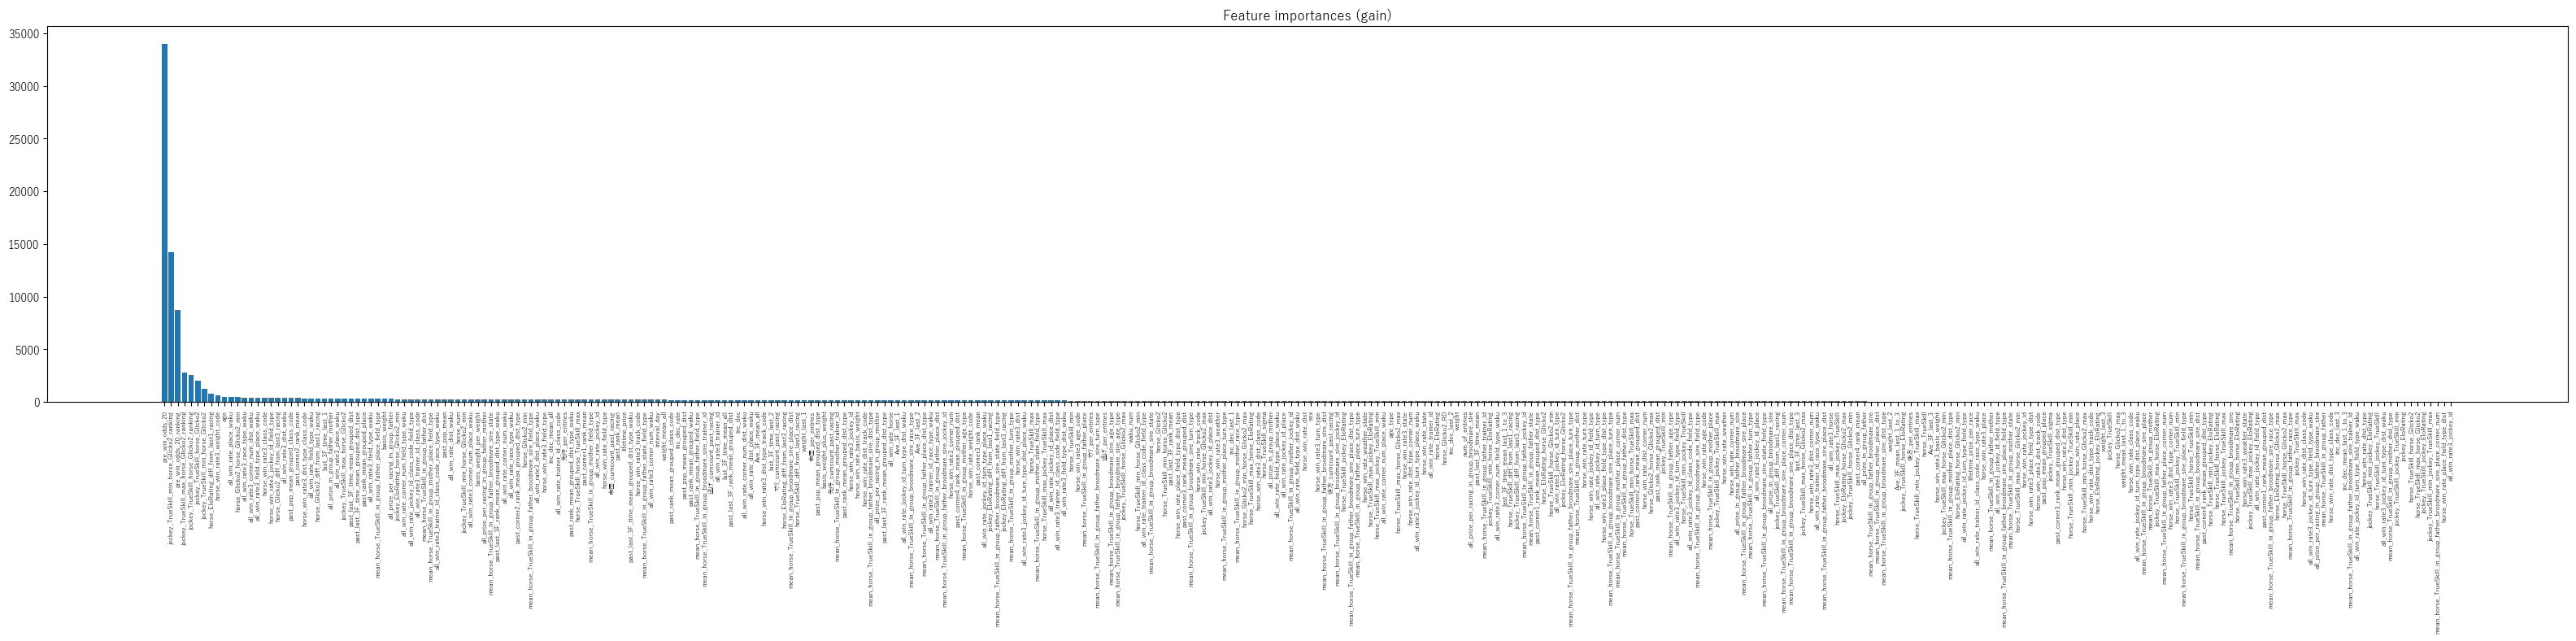

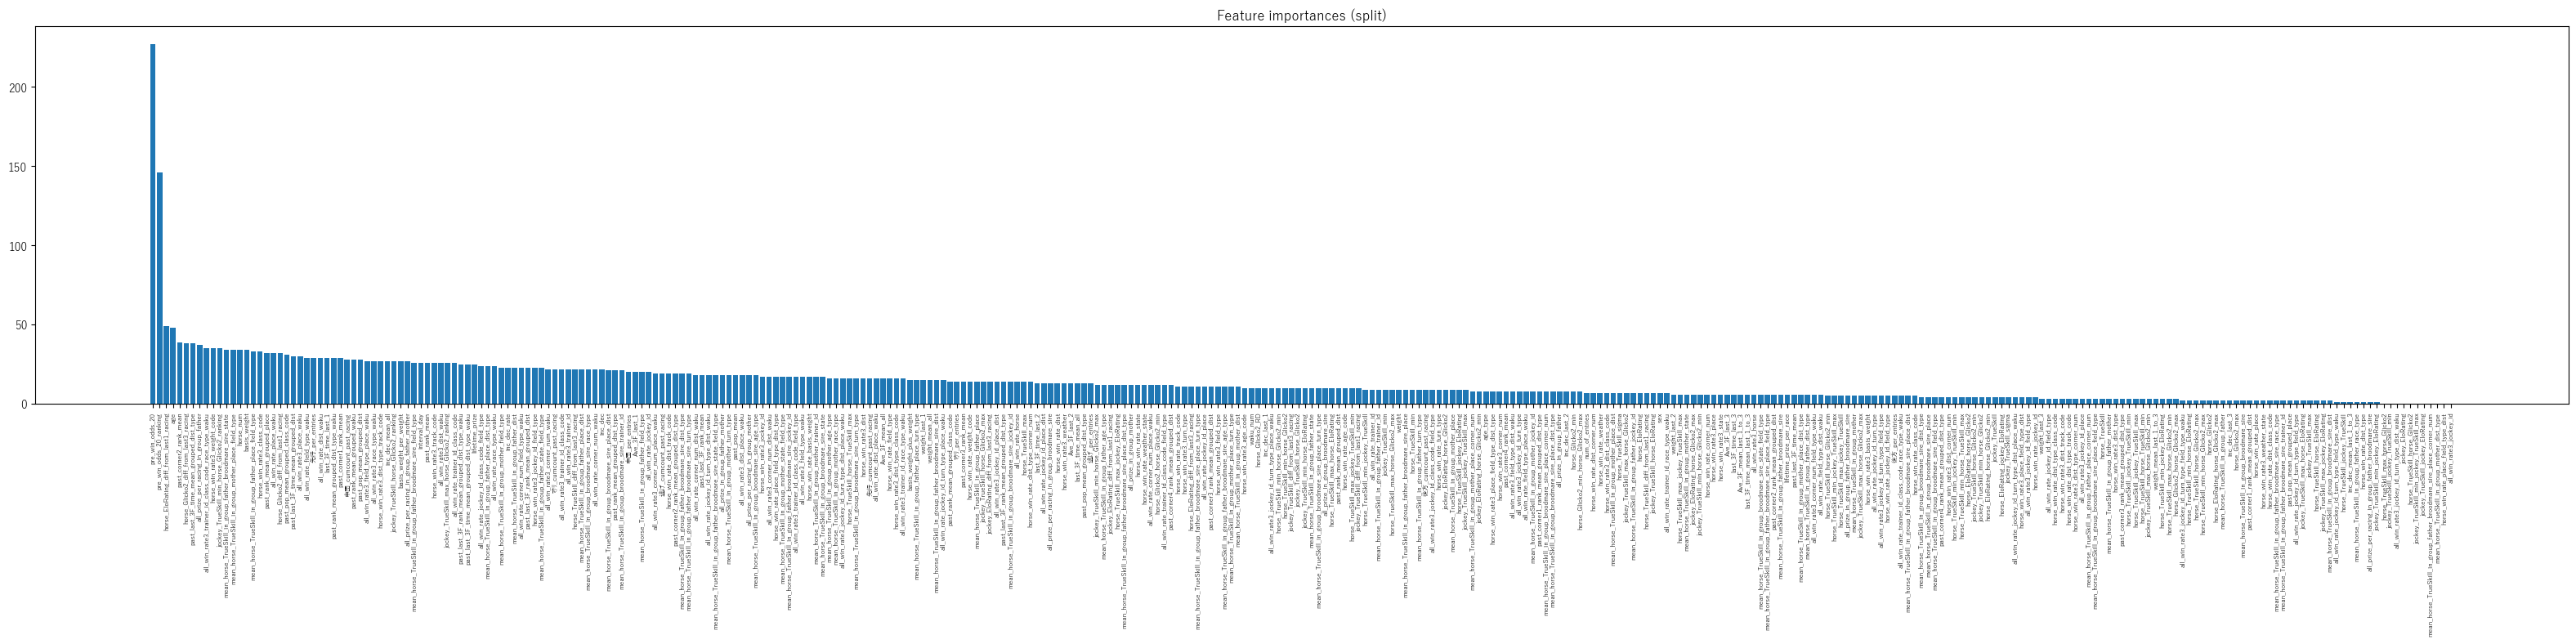

logloss: [(5, 1.2257656622255688), (6, 1.1308579375397378), (7, 0.9609158499177207), (8, 0.9596112998057446), (9, 0.8748439549026981), (10, 0.8151392882217265), (11, 0.764446835844857), (12, 0.7194171229228933), (13, 0.6858275337816387), (14, 0.6602399973902314), (15, 0.6296737193228661), (16, 0.5897101580186297), (17, 0.5652029470885381), (18, 0.5441480555986771)]
logloss is saved


ValueError: multi_class must be in ('ovo', 'ovr')

In [10]:
memo = "saving score test"
model, df_pred = model_tuner_multi.multi_lightGBM(df4, feature_col2, memo=memo, n_trials=2, save_result=True, visualization=True)

In [23]:
id = df_pred["id_for_fold"].unique()[60]
tmp = df_pred[df_pred["id_for_fold"] == id][["year", "month", "day", "horse", "pred_class_1", "pred_class_2", "pred_class_3", "target"]]
tmp

,year,month,day,horse,pred_class_1,pred_class_2,pred_class_3,target
222090,2024,10,26,ワンウェイトゥヘル,0.017516,0.035314,0.042620,3
222091,2024,10,26,プルクワ,0.021665,0.032362,0.060939,0
222092,2024,10,26,モンテシート,0.266643,0.199908,0.128837,2
222093,2024,10,26,ホウオウライダイ,0.107426,0.142514,0.169088,0
222094,2024,10,26,シュバルツマサムネ,0.061818,0.068283,0.082720,0
222095,2024,10,26,ヴィータレヴィス,0.073986,0.078424,0.093514,0
222096,2024,10,26,ラヴリーチェリー,0.003905,0.005637,0.009097,0
222097,2024,10,26,レストプレドゥモア,0.063647,0.100074,0.104419,0
222098,2024,10,26,スナークピカソ,0.054784,0.073899,0.073973,0
222099,2024,10,26,アイサンサン,0.240619,0.176750,0.121264,1


In [11]:
tmp = df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

[autoreload of model_tuner_multi failed: Traceback (most recent call last):
  File "c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\IPython\extensions\autoreload.py", line 280, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 533, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
UnicodeDecodeError: 'cp932' codec can't decode byte 0x86 in position 507: illegal multibyte sequence
]


KeyError: "['pred'] not in index"

In [ ]:
df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False).tail()

,id_for_fold,horse,pred
251116,2025060805030203,キャバリエクエスト,6.875443e-16
250900,2025060705030107,マジョレル,6.776239e-16
248304,2025051705020705,レオプレセア,6.573031e-16
251244,2025060809030207,フルオブエナジー,6.071034e-16
247317,2025051005020505,パリモード,5.116316e-16


In [ ]:
df_pred[["race_id", "id_for_fold", "horse", "pred", "win_odds", "target"]].to_csv("df_pred.csv", index=False)

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

def plot_calibration_curve(df, y_true_col="target", y_pred_col="pred", title="Calibration curve", n_bins=50):
    y_true = df[y_true_col]
    y_pred = df[y_pred_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins, strategy='uniform')

    # 件数を計算
    bin_edges = np.linspace(0, 1, n_bins+1)  # n_bins+1個のbin境界
    bin_ids = np.digitize(y_pred, bin_edges) - 1 

    counts = []
    for i in range(n_bins):
        counts.append(np.sum(bin_ids == i))

    print("Breier Score:",brier_score_loss(y_true, y_pred))
    print("LogLoss:", log_loss(y_true, y_pred))

    # グラフ描画
    plt.plot(prob_pred, prob_true, marker="o", markersize=4)
    plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7, color="black")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.title(title)

    # 件数をマーカー上に表示
    for x, y, count in zip(prob_pred, prob_true, counts):
        plt.text(x, y + 0.02, str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


Breier Score: 0.05693398605038691
LogLoss: 0.20288061810922078


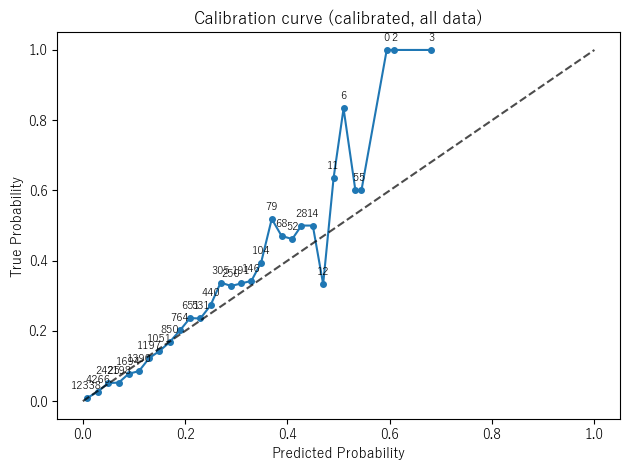

In [ ]:
plot_calibration_curve(df_pred, title="Calibration curve (calibrated, all data)")

Breier Score: 0.03842488086115884
LogLoss: 0.1551610235460004


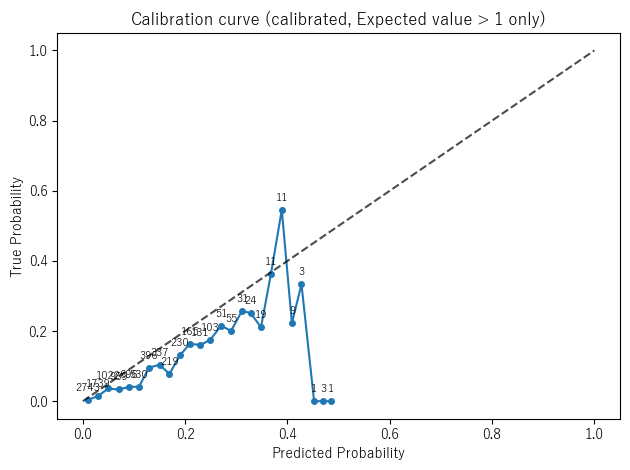

In [ ]:
df_pred["exp_value"] = df_pred["win_odds"] * df_pred["pred"]
plot_calibration_curve(df_pred[df_pred["exp_value"] > 1], title="Calibration curve (calibrated, Expected value > 1 only)")

In [ ]:
tmp = df_pred[["race_id", "id_for_fold", "year", "month", "day", "place", "horse", "pred", "target"]]

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,past_last_3F_rank_mean_grouped_dist_type_waku,past_last_3F_time_mean,past_last_3F_time_mean_grouped_dist,past_last_3F_time_mean_grouped_dist_type,past_last_3F_time_mean_grouped_dist_type_waku,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_T